## Imports

In [1]:
import os
import random
import time
from collections import namedtuple
from copy import deepcopy
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn.functional as F
import torchvision
from albumentations import (
    CenterCrop,
    Compose,
    HorizontalFlip,
    Normalize,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    VerticalFlip,
)
from albumentations.pytorch import ToTensor
from ranger import Ranger
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.utils import make_grid

In [2]:
from nn_utils import (
    AlbuSingleAttrDataset,
    ContrastiveLossD,
    ContrastiveLossLecun,
    SiameseNetworkDataset,
    get_image,
    make_oneshot_task,
    test_oneshot_cross_entropy,
    test_oneshot_L2,
    test_oneshot_prob_single_neuron,
)

# from siamese_net_archs import SiameseNetworkPretrainedBackbone
from utils import error_plot, performance_metrics

## Load jupyter extension

In [3]:
# %load_ext pycodestyle_magic
# %flake8_on --max_line_length 99
# %load_ext autoreload
# %autoreload 2

## Parameters

In [4]:
batch_size = bs = 16
im_size = 299
im_crop = 224
path_to_nn_weights = "../Fashion_datasets/Pretrained_weights/"
path_to_data = "../Fashion_datasets/my_dataset/"
target_attr = "color"

In [5]:
# Parameters
target_attr = "neck"


In [6]:
def parse_column(df, column_to_parse, num_splits, pat=" "):
    """create new columns based on split old one.

    Args:
        df - pandas Dataframe
        column_to_parse - str, column name exists in df
        num_splits - int, number of new columns
        pat - str, pat

    Returns:
        modified DataFrame
    """
    df = df.copy()
    df_temp = (
        df[column_to_parse]
        .str.split(pat=pat, expand=True, n=num_splits)
        .rename(lambda x: "%s_part_{}".format(x + 1) % (column_to_parse), axis=1)
    )
    df = pd.concat([df, df_temp], axis=1)
    return df

## Check and remove bad images

## Create labels dataframe 

In [7]:
def create_labels_df_from_folders(path_to_data):
    """Scans the folder structure and creates a dataframe with class paths and labels.
    The first part of the folder name of the dress - the type of neck,
    the second-the color of clothing
    
    Folder structure:
    - path_to_data_folder
        - roundneck_black
            - img1.jpg
            ...
            - img100.jpg
        - vneck_white
            - img245.jpg
            - ...
        - roundneck_white
            - img245.jpg
            - ...
        - ...
    Args:
        path_to_data - path to folder with subfolders

    Returns:
        pandas Dataframe with path, neck, color columns
    """
    subfolders = [f for f in os.scandir(path_to_data) if f.is_dir()]
    d = {}
    for folder in subfolders:
        for file in os.listdir(folder):
            d[os.path.join(folder, file)] = folder.name
    labels_df = pd.DataFrame.from_dict(data=d, orient="index", columns=["class"])
    labels_df = labels_df.reset_index()
    labels_df = parse_column(labels_df, "class", 1, pat="_").rename(
        columns={"class_part_1": "neck", "class_part_2": "color", "index": "path"}
    )
    labels_df = labels_df.drop(columns=["class"])
    return labels_df

In [8]:
labels_df = create_labels_df_from_folders(path_to_data)
labels_df.head()

,path,neck,color
0,../Fashion_datasets/my_dataset/roundneck_black...,roundneck,black
1,../Fashion_datasets/my_dataset/roundneck_black...,roundneck,black
2,../Fashion_datasets/my_dataset/roundneck_black...,roundneck,black
3,../Fashion_datasets/my_dataset/roundneck_black...,roundneck,black
4,../Fashion_datasets/my_dataset/roundneck_black...,roundneck,black


### label encoding attribute columns

In [9]:
X_feat_is_cat = np.where(
    (labels_df.dtypes == "category") | (labels_df.dtypes == "object")
)[0]

cols_need_mapped = [
    x for x in labels_df.columns[X_feat_is_cat] if x not in ["path", "skup_label"]
]
print(cols_need_mapped)

['neck', 'color']

### Create mapper dict col:{old_label:int_label}

In [10]:
mapper = {
    col: {
        cat: n for n, cat in enumerate(labels_df[col].astype("category").cat.categories)
    }
    for col in labels_df[cols_need_mapped]
}

for c in cols_need_mapped:
    labels_df[c] = labels_df[c].map(mapper[c])

In [11]:
inv_mapper = {
    k_name: {v: k for k, v in v_dict.items()} for k_name, v_dict in mapper.items()
}

In [12]:
class_to_idx = mapper[target_attr]
idx_to_class = inv_mapper[target_attr]

In [13]:
name_to_attr = {
    x[0]: target_attr + " = " + idx_to_class[x[1]]
    for x in labels_df[["path", target_attr]].values
}
encoder = name_to_attr

### Check Nones in dataset

In [14]:
labels_df = labels_df.dropna(subset=[target_attr])

In [15]:
labels_df.head()

,path,neck,color
0,../Fashion_datasets/my_dataset/roundneck_black...,0,0
1,../Fashion_datasets/my_dataset/roundneck_black...,0,0
2,../Fashion_datasets/my_dataset/roundneck_black...,0,0
3,../Fashion_datasets/my_dataset/roundneck_black...,0,0
4,../Fashion_datasets/my_dataset/roundneck_black...,0,0


In [16]:
assert (
    labels_df[target_attr].isna().sum() == 0
), f"fill or drop rows with nan in {target_attr} column"

## split indexes to train/valid/test
train size ~ 50% , valid size ~50%, test size = 1 img

In [17]:
np.random.seed(5)

In [18]:
idx_arr = deepcopy(labels_df.index.values)
print("all_dataset shape =", len(idx_arr))
train_size = int(0.5 * len(idx_arr))
val_size = int(0.5 * len(idx_arr))
test_size = 1  # len(idx_arr) - train_size - val_size
np.random.shuffle(idx_arr)

all_dataset shape =

1784

Let's define indexes in labels_df dataframe related to train, valid, test parts

In [19]:
train_idx = idx_arr[:train_size]
val_idx = idx_arr[train_size : val_size + train_size]
test_idx = idx_arr[-test_size:]
print(
    "train_size: {} samples, valid_size: {} samples, test_size: {} samples".format(
        train_size, val_size, test_size
    )
)

train_size: 892 samples, valid_size: 892 samples, test_size: 1 samples

### Calculate mean and std of all dataset

In [20]:
def normalization_parameter(dataloader):
    mean = 0.0
    std = 0.0
    nb_samples = len(dataloader.dataset)
    for data, *_ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(), std.numpy()

### calculate mean and std of all our data

In [21]:
%%time

train_transforms_base = Compose([Resize(im_size, im_size), ToTensor()])


all_data = SiameseNetworkDataset(
    label_df=labels_df,
    target_attr=target_attr,
    indexes=idx_arr,
    transform=train_transforms_base,
)

all_loader = DataLoader(all_data, batch_size=bs, shuffle=True)
mean, std = normalization_parameter(all_loader)
print(mean, std)

[0.73884624 0.7367798  0.746662  ]

[0.24593039 0.24137233 0.23513906]

Wall time: 59.5 s

In [22]:
# image net stats
# mean=np.array([0.485, 0.456, 0.406])
# std=np.array([0.229, 0.224, 0.225])

### Check normalization

In [23]:
train_transforms_check = Compose(
    [Resize(im_size, im_size), Normalize(mean, std), ToTensor()]
)

all_data = SiameseNetworkDataset(
    label_df=labels_df,
    target_attr=target_attr,
    indexes=idx_arr,
    transform=train_transforms_check,
)

all_loader = DataLoader(all_data, batch_size=bs, shuffle=True)
new_mean, new_std = normalization_parameter(all_loader)
is_normalize = (
    np.isclose(new_mean, 0, atol=0.01).all() & np.isclose(new_std, 1, atol=0.01).all()
)
assert is_normalize, "mean must be ~ 0, std ~ 1"

## define image transforms

### By default there is a minimum set of transformations

In [24]:
image_transforms = {
    "train": Compose(
        [
            Resize(im_crop, im_crop),
            # RandomResizedCrop(height=im_crop, width=im_crop, scale=(0.95, 1.0)),
            # Rotate(limit=30),
            # HorizontalFlip(),
            # VerticalFlip(),
            Normalize(mean, std),
            ToTensor(),
        ]
    ),
    "valid": Compose(
        [
            Resize(int(im_crop), int(im_crop)),
            # CenterCrop(height=im_crop, width=im_crop),
            Normalize(mean, std),
            ToTensor(),
        ]
    ),
}

In [25]:
# inverse normalization for image plot

inv_normalize = Normalize(
    mean=-1 * np.divide(mean, std),
    std=1 / std,
    max_pixel_value=1,  # in pytorch tensor values between 0-1
)

## create pytorch datasets and dataloaders

In [26]:
data = {
    "train": SiameseNetworkDataset(
        label_df=labels_df,
        target_attr=target_attr,
        indexes=train_idx,
        transform=image_transforms["train"],
    ),
    "valid": SiameseNetworkDataset(
        label_df=labels_df,
        target_attr=target_attr,
        indexes=val_idx,
        transform=image_transforms["valid"],
    ),
    "test": SiameseNetworkDataset(
        label_df=labels_df,
        target_attr=target_attr,
        indexes=test_idx,
        transform=image_transforms["valid"],
    ),
}
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data["train"])
valid_data_size = len(data["valid"])
test_data_size = len(data["test"])

# Create iterators for the Data loaded using DataLoader module
train_data = DataLoader(data["train"], batch_size=bs, shuffle=True)
valid_data = DataLoader(data["valid"], batch_size=bs, shuffle=True)
test_data = DataLoader(data["test"], batch_size=bs, shuffle=True)

## Plot subsamples

In [27]:
def class_plot(data, encoder, inv_normalize=None, n_figures=12):
    """
    Visualize some pairs from siamese dataset

    Args:
        data: pytorch dataset, dataset output format:img_0,img_1,label,name0,name1
            img_0,img_1 - numpy arrays
            label - number, 1 - images has same class, 0 - differ
            name0, name1 - str
        encoder : dict, {name : original class of image}
        inv_normalize: albumentation transforms
        n_figures : number of plots

    Returns:
        plots with titles
    """
    n_row = int(n_figures / 4)
    fig, axes = plt.subplots(figsize=(28, 10), nrows=n_row, ncols=4)
    for ax in axes.flatten():
        rand_idx = random.randint(0, len(data) - 1)
        (img_0, img_1, label, name0, name1) = data[rand_idx]
        # image is torch tensor
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        img_0 = img_0.numpy().transpose(1, 2, 0)
        img_1 = img_1.numpy().transpose(1, 2, 0)

        if inv_normalize is not None:
            img_0 = inv_normalize(image=img_0)["image"]
            img_1 = inv_normalize(image=img_1)["image"]
        image = np.hstack([img_0, img_1]).clip(0, 1)
        label = int(label)
        if label:
            string_label = "SAME (1): "
        else:
            string_label = "DIFFER(0): "  # encoder[label]
        string_label += encoder[name0] + " | " + encoder[name1]
        ax.imshow(image)
        ax.set_title(string_label)
        ax.axis("off")
    plt.show()

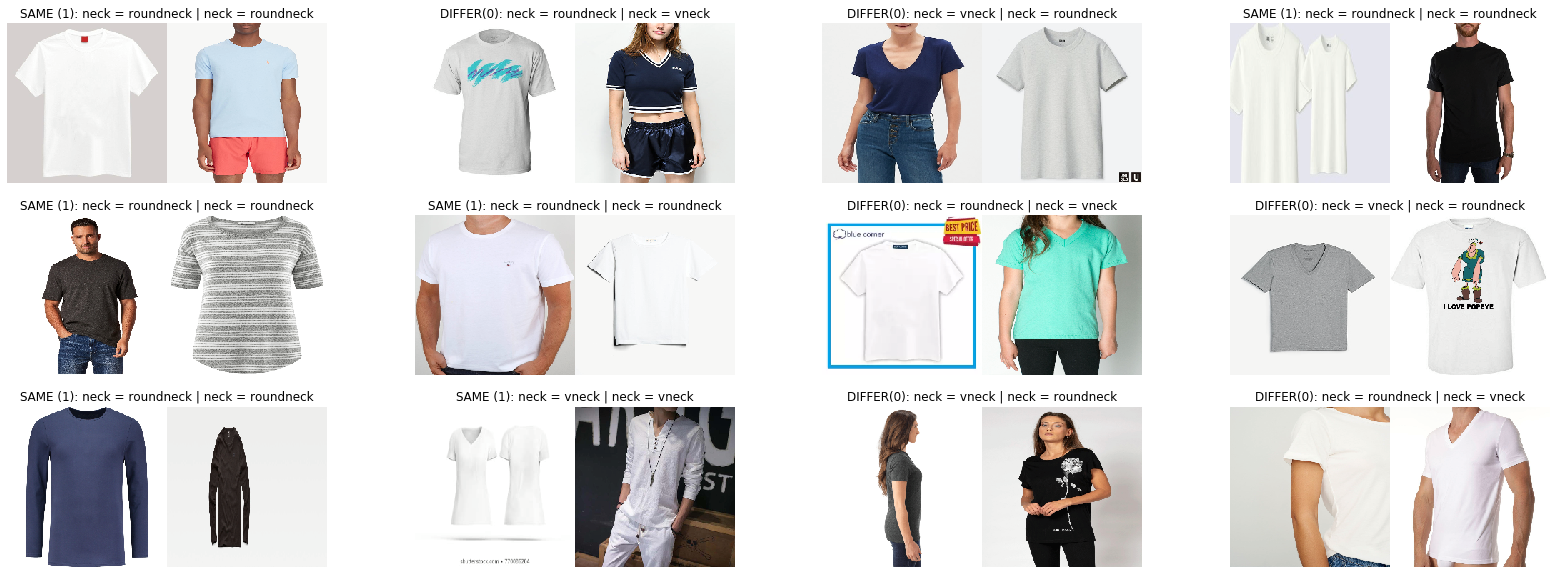

In [28]:
class_plot(data["train"], encoder=encoder, inv_normalize=inv_normalize)

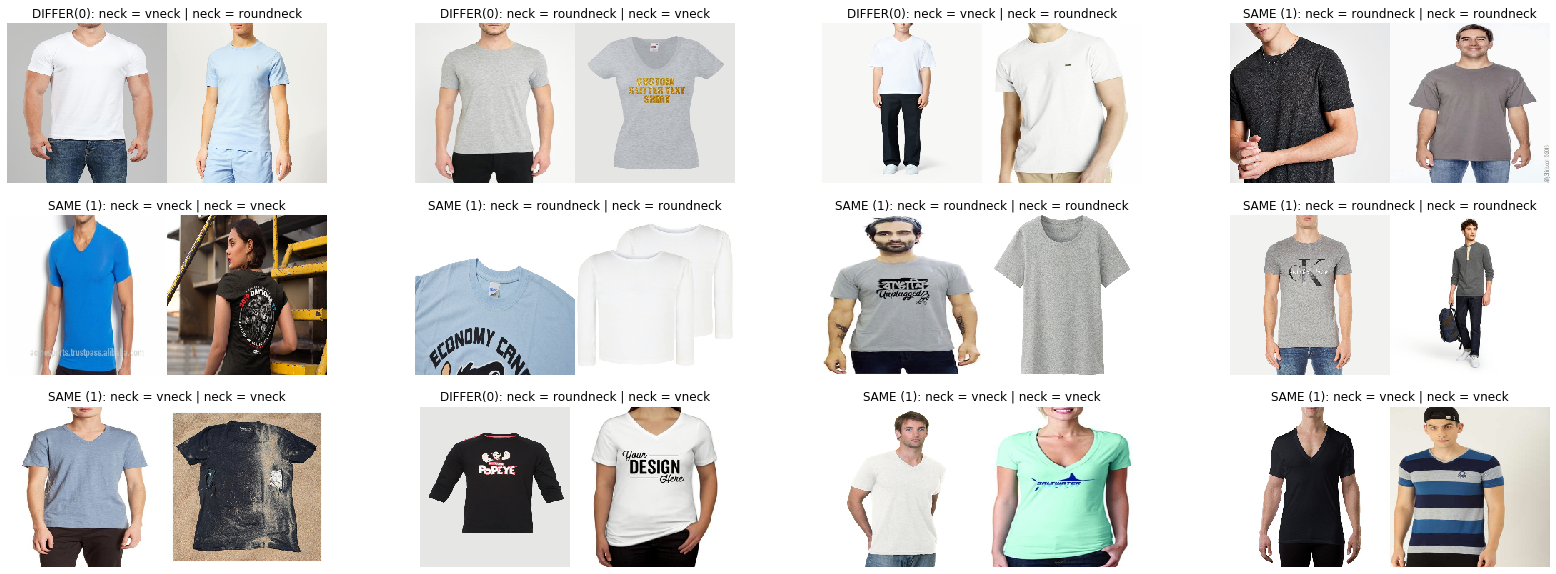

In [29]:
class_plot(data["valid"], encoder=encoder, inv_normalize=inv_normalize)

## Check labels in target column

In [30]:
print("unique labels in {} attribute:".format(target_attr), idx_to_class)
num_classes = len(labels_df[target_attr].unique())
print("num classes in attr:", num_classes)

unique labels in neck attribute:

{0: 'roundneck', 1: 'vneck'}

num classes in attr:

2

In [31]:
assert labels_df[target_attr].unique().min() == 0

## Load resnet network and unfreeze some layers

In [32]:
resnet = torchvision.models.resnet50(pretrained=False)
state = torch.load(path_to_nn_weights + "resnet50-19c8e357.pth")
resnet.load_state_dict(state)

# for name, child in resnet.named_children():
#     print(name)

for name, child in resnet.named_children():
    if name in ["fc", "avgpool", "layer4", "layer3"]:
        print(name + " is unfrozen")
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + " is frozen")
        for param in child.parameters():
            param.requires_grad = False

conv1 is frozen

bn1 is frozen

relu is frozen

maxpool is frozen

layer1 is frozen

layer2 is frozen

layer3 is unfrozen

layer4 is unfrozen

avgpool is unfrozen

fc is unfrozen

## custom model with pretrained backbone

In [33]:
class SiameseNetworkPretrainedBackbone(nn.Module):
    def __init__(self, pretrained_resnet, out_act, out_neurons):
        super().__init__()
        assert out_act in [
            "no_act",
            "sigmoid",
        ], "select out act from ['no_act', 'sigmoid']"
        self.out_act = out_act
        self.backbone = pretrained_resnet
        backbone_fc_outputs = pretrained_resnet.fc.out_features
        self.linear2 = nn.Linear(backbone_fc_outputs, out_neurons)

    def forward_once(self, x):
        output = self.backbone(x)
        output = output.view(output.size()[0], -1)
        output = F.relu(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        output_res = torch.abs(output1 - output2)
        output_res = self.linear2(output_res)
        if self.out_act == "sigmoid":
            output_res = torch.sigmoid(output_res)
        return output_res

In [34]:
model = SiameseNetworkPretrainedBackbone(
    deepcopy(resnet), out_act="sigmoid", out_neurons=1
)
loss_func = nn.BCELoss()
out_mode = "prob_single_neuron"
test_oneshot_func = test_oneshot_prob_single_neuron

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)
# Ranger is new optimizer combined Radam and Lookahead techniques
# https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
# optimizer = Ranger(model.parameters(), )
# but Adam is good default choice
optimizer = optim.Adam(model.parameters(), lr=0.00005)
scheduler = CosineAnnealingWarmRestarts(optimizer, 5)

device:

cuda

In [36]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

## define parameters

In [37]:
torch.cuda.empty_cache()

In [38]:
counter = []
history = []

In [39]:
EPOCHS = 20
N_way = 10  # how many classes for testing one-shot tasks
n_val = 75  # how many one-shot tasks to validate on

### One shot test - Siamese network
    

Note that, for every pair of input images, our model generates a similarity score between 0 and 1(probability of class 1). But just looking at the score its difficult to ascertain whether the model is really able to recognize similar characters and distinguish dissimilar ones.

A nice way to judge the model is N-way one shot learning.  4-shot-learning
- [img_class_X ,img_class_Y] - probability1
- [img_class_X ,img_class_X] - probability2
- [img_class_X ,img_class_Z] - probability3
- [img_class_X ,img_class_Y] - probability4  

Thus if probability2 happens to be the maximum probability, we treat this as a correct prediction otherwise we consider this as an incorrect prediction. Repeating this procedure ‘k’ times, we can calculate the percentage of correct predictions  


In [40]:
def img_tensor_plot(image, inv_normalize=None):
    image = image.cpu().numpy().squeeze()
    image = image.transpose(1, 2, 0)
    if inv_normalize is not None:
        augmented = inv_normalize(image=image)
        image = augmented["image"]
    image = image.clip(0, 1)
    plt.imshow(image)
    plt.show()

one shot task labels:

tensor([0., 1., 0.])

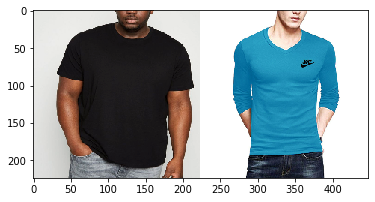

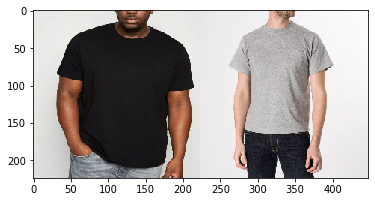

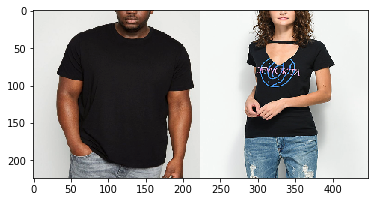

In [41]:
img0a, img1a, targets_a = make_oneshot_task(3, valid_data)
concatenated = torch.cat((img0a, img1a), 3)
print("one shot task labels:", targets_a)
for i in range(concatenated.size(0)):
    im = concatenated[i].squeeze()
    img_tensor_plot(im, inv_normalize=inv_normalize)

In [42]:
def eval_f(model):

    with torch.no_grad():
        model.eval()
        avg_acc = test_oneshot_func(
            model, N_way, n_val, valid_data, device, verbose=True
        )
        return avg_acc

## Train

In [43]:
for epoch in tqdm(range(EPOCHS)):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch + 1, EPOCHS))

    # Set to training mode
    model.train()

    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0

    valid_loss = 0.0
    valid_acc = 0.0

    for i, inputs in tqdm(enumerate(train_data)):

        img0, img1, label, *_ = inputs
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)
        if out_mode == "cross_entropy":
            label = label.type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        output = model(img0, img1)
        if out_mode == "prob_single_neuron":
            output = output.squeeze()
        if isinstance(output, tuple):
            output1 = output[0]
            output2 = output[1]
            loss = loss_func(output1, output2, label)
        else:
            loss = loss_func(output, label)
        if torch.isnan(loss).any():
            raise ValueError("loss is nan")
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * img0.size(0)

    scheduler.step()
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, inputs in enumerate(valid_data):
            img0, img1, label, *_ = inputs
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)
            if out_mode == "cross_entropy":
                label = label.type(torch.LongTensor).to(device)
            output = model(img0, img1)
            if out_mode == "prob_single_neuron":
                output = output.squeeze()

            if isinstance(output, tuple):
                output1 = output[0]
                output2 = output[1]
                loss = loss_func(output1, output2, label)
            else:
                loss = loss_func(output, label)

            # Compute the total loss for the batch and add it to valid_loss
            valid_loss += loss.item() * img0.size(0)

        # Find average training loss and training accuracy
        avg_train_loss = train_loss / train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss / valid_data_size

        avg_valid_acc = eval_f(model)

        history.append([avg_train_loss, avg_valid_loss, avg_valid_acc])

        epoch_end = time.time()

        print("Epoch : {:03d},\nTraining  : Loss: {:.4f}".format(epoch, avg_train_loss))
        print(
            "Validation: Loss: {:.4f}, Accuracy: {:.1f}%:,\n\t Time: {:.4f}s".format(
                avg_valid_loss, avg_valid_acc, epoch_end - epoch_start
            )
        )

Epoch: 1/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 9.3% 10 way one-shot learning accuracy 


Epoch : 000,
Training  : Loss: 0.7514

Validation: Loss: 0.7693, Accuracy: 9.3%:,
	 Time: 94.1801s

Epoch: 2/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 13.3% 10 way one-shot learning accuracy 


Epoch : 001,
Training  : Loss: 0.7495

Validation: Loss: 0.7602, Accuracy: 13.3%:,
	 Time: 96.4452s

Epoch: 3/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 6.7% 10 way one-shot learning accuracy 


Epoch : 002,
Training  : Loss: 0.7434

Validation: Loss: 0.7203, Accuracy: 6.7%:,
	 Time: 94.3207s

Epoch: 4/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 8.0% 10 way one-shot learning accuracy 


Epoch : 003,
Training  : Loss: 0.7299

Validation: Loss: 0.7192, Accuracy: 8.0%:,
	 Time: 92.7743s

Epoch: 5/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 8.0% 10 way one-shot learning accuracy 


Epoch : 004,
Training  : Loss: 0.7172

Validation: Loss: 0.7228, Accuracy: 8.0%:,
	 Time: 92.9149s

Epoch: 6/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 18.7% 10 way one-shot learning accuracy 


Epoch : 005,
Training  : Loss: 0.7209

Validation: Loss: 0.7551, Accuracy: 18.7%:,
	 Time: 94.8831s

Epoch: 7/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 9.3% 10 way one-shot learning accuracy 


Epoch : 006,
Training  : Loss: 0.7329

Validation: Loss: 0.7092, Accuracy: 9.3%:,
	 Time: 95.0237s

Epoch: 8/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 14.7% 10 way one-shot learning accuracy 


Epoch : 007,
Training  : Loss: 0.7167

Validation: Loss: 0.7099, Accuracy: 14.7%:,
	 Time: 95.2424s

Epoch: 9/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 14.7% 10 way one-shot learning accuracy 


Epoch : 008,
Training  : Loss: 0.7036

Validation: Loss: 0.7005, Accuracy: 14.7%:,
	 Time: 94.6176s

Epoch: 10/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 9.3% 10 way one-shot learning accuracy 


Epoch : 009,
Training  : Loss: 0.6906

Validation: Loss: 0.6968, Accuracy: 9.3%:,
	 Time: 94.2270s

Epoch: 11/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 28.0% 10 way one-shot learning accuracy 


Epoch : 010,
Training  : Loss: 0.6841

Validation: Loss: 0.6435, Accuracy: 28.0%:,
	 Time: 94.3364s

Epoch: 12/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 54.7% 10 way one-shot learning accuracy 


Epoch : 011,
Training  : Loss: 0.5604

Validation: Loss: 0.4774, Accuracy: 54.7%:,
	 Time: 95.3049s

Epoch: 13/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 76.0% 10 way one-shot learning accuracy 


Epoch : 012,
Training  : Loss: 0.4384

Validation: Loss: 0.3778, Accuracy: 76.0%:,
	 Time: 93.1961s

Epoch: 14/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 81.3% 10 way one-shot learning accuracy 


Epoch : 013,
Training  : Loss: 0.3662

Validation: Loss: 0.3307, Accuracy: 81.3%:,
	 Time: 94.5082s

Epoch: 15/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 84.0% 10 way one-shot learning accuracy 


Epoch : 014,
Training  : Loss: 0.2878

Validation: Loss: 0.3059, Accuracy: 84.0%:,
	 Time: 92.4306s

Epoch: 16/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 76.0% 10 way one-shot learning accuracy 


Epoch : 015,
Training  : Loss: 0.3026

Validation: Loss: 0.3338, Accuracy: 76.0%:,
	 Time: 92.3056s

Epoch: 17/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 86.7% 10 way one-shot learning accuracy 


Epoch : 016,
Training  : Loss: 0.2646

Validation: Loss: 0.2894, Accuracy: 86.7%:,
	 Time: 92.7899s

Epoch: 18/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 92.0% 10 way one-shot learning accuracy 


Epoch : 017,
Training  : Loss: 0.2048

Validation: Loss: 0.2152, Accuracy: 92.0%:,
	 Time: 94.7269s

Epoch: 19/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 96.0% 10 way one-shot learning accuracy 


Epoch : 018,
Training  : Loss: 0.1619

Validation: Loss: 0.1705, Accuracy: 96.0%:,
	 Time: 94.4770s

Epoch: 20/20

Evaluating model on 75 random 10 way one-shot learning tasks ... 


Got an average of 94.7% 10 way one-shot learning accuracy 


Epoch : 019,
Training  : Loss: 0.1646

Validation: Loss: 0.1463, Accuracy: 94.7%:,
	 Time: 93.0086s

## plot losses

In [44]:
def acc_plot_one_shot(acc):
    plt.figure(figsize=(10, 5))
    plt.plot(acc)
    plt.title("oneshot acc plot")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

train

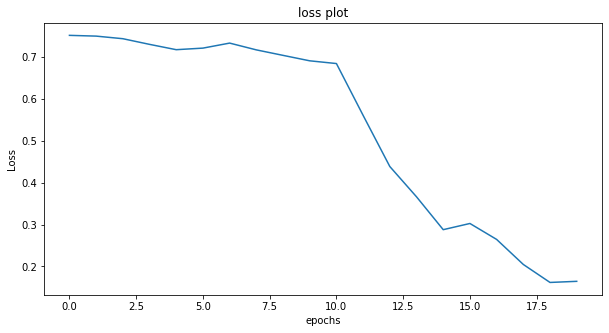

In [45]:
print("train")
error_plot(np.array([x[0] for x in history]).clip(0, 10))

validation

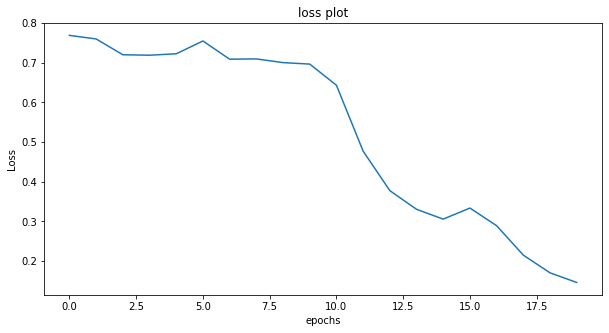

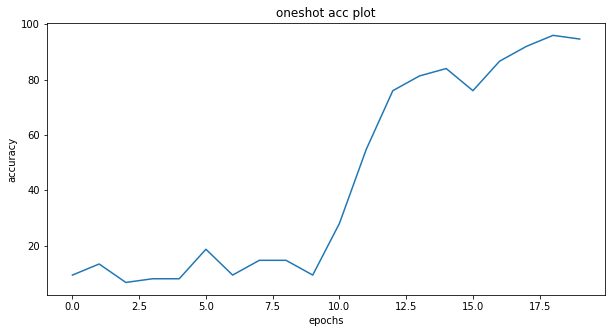

In [46]:
print("validation")
error_plot(np.array([x[1] for x in history]).clip(0, 10))
acc_plot_one_shot([round(x[2], 3) for x in history])

## Plot random pairs from validation dataset 

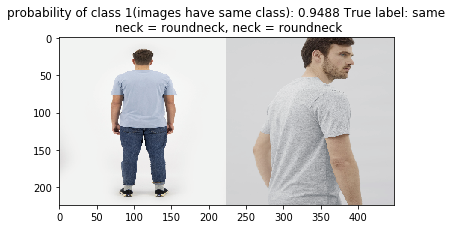

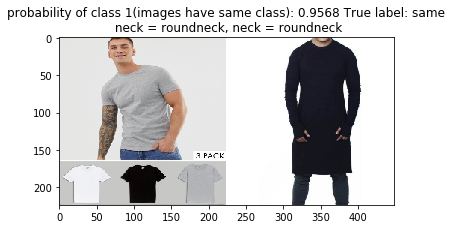

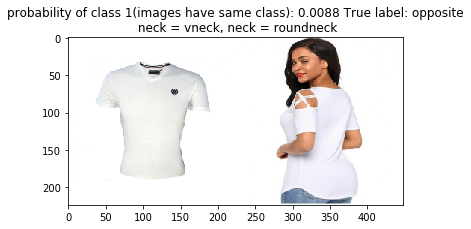

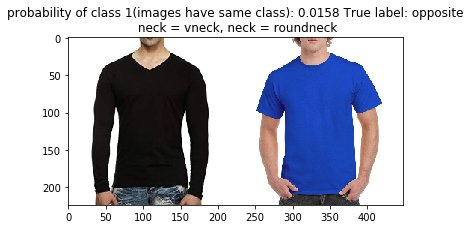

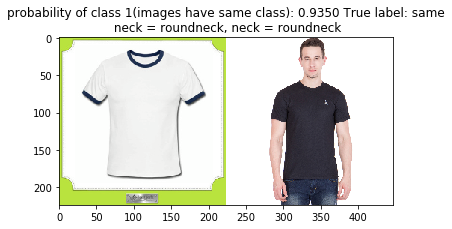

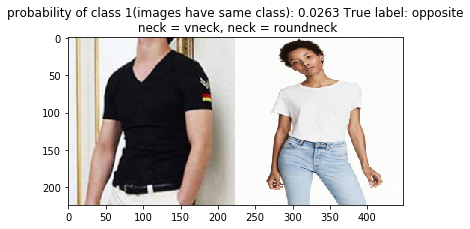

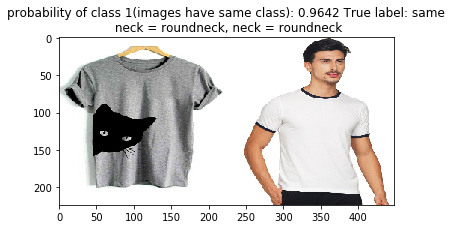

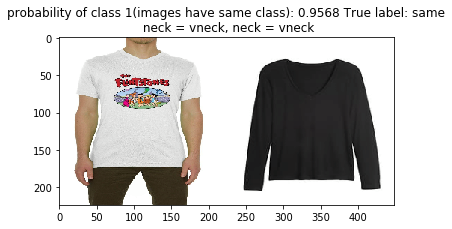

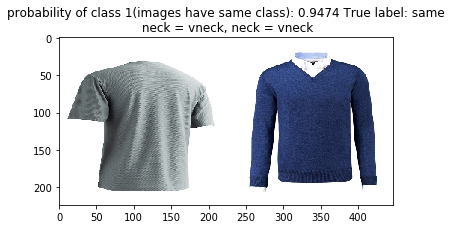

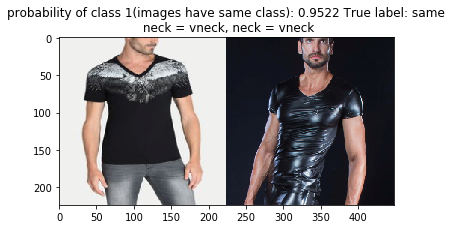

In [47]:
valid_encoder = encoder
test_dataloader = DataLoader(data["valid"], batch_size=1, shuffle=True)
model.eval()
counter = 0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, batch in enumerate(test_dataloader, 0):
    x0, x1, label, name0, name1 = batch
    concatenated = torch.cat((x0, x1), 3)
    if label == list_0:
        label = "opposite"
    else:
        label = "same"

    if out_mode == "prob_single_neuron":
        prob_of_same = model(x0.to(device), x1.to(device))
        title = "probability of class 1(images have same class): {:.4f} True label: {}\n {}, {}".format(
            prob_of_same.item(), label, valid_encoder[name0[0]], valid_encoder[name1[0]]
        )
    if out_mode == "L2":
        output1, output2 = model(x0.to(device), x1.to(device))
        eucledian_distance = F.pairwise_distance(output1, output2)
        title = "eucledian_distance: {:.4f} True label: {}\n class {}, class {}".format(
            eucledian_distance.item(),
            label,
            valid_encoder[name0[0]],
            valid_encoder[name1[0]],
        )

    if out_mode == "cross_entropy":
        output = model(x0.to(device), x1.to(device))
        prob = F.softmax(output, dim=1)
        prob_of_same = prob[:, 1]
        title = "probability of class 1(images have same class): {:.4f} True label: {}\n {}, {}".format(
            prob_of_same.item(), label, valid_encoder[name0[0]], valid_encoder[name1[0]]
        )

    plt.title(title)
    img_tensor_plot(concatenated, inv_normalize=inv_normalize)
    counter = counter + 1
    if counter == 10:
        break

In [48]:
%%time
acc = test_oneshot_func(model, 10, 400, valid_data, device, verbose=True)

Evaluating model on 400 random 10 way one-shot learning tasks ... 


Got an average of 94.8% 10 way one-shot learning accuracy 


Wall time: 1min 41s